# DIPY Reconstruction DTI

`10-diff-westin-2002.ipynb` ver. 20200429

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994], it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser, join
import dipy
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
# dipy.reconst is for the reconstruction algorithms which we use to create voxel models from the raw da
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity, axial_diffusivity, radial_diffusivity, color_fa
home = expanduser('~')

In [2]:
dipy.__version__

'1.1.1'

### Diffusion data (.nii.gz, .bvec, .bval) in `westin_2002` directory 

In [3]:
dname = join(os.getcwd(), 'data', 'westin_2002')

## Preliminary exploration

In [4]:
fn = 'D6_19x7x128x128'
fdwi = join(dname, '%s.nii.gz' % fn)
fbval = join(dname, '%s.bval' % fn)
fbvec = join(dname, '%s.bvec' % fn)

data, affine, img = load_nifti(fdwi, return_img=True)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [5]:
bvals, bvecs

(array([   0., 1000., 1000., 1000., 1000., 1000., 1000.]),
 array([[ 0.,  0.,  0.],
        [ 1.,  0.,  1.],
        [-1.,  0.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1., -1.],
        [ 1.,  1.,  0.],
        [-1.,  1.,  0.]]))

In [6]:
# Normalize the b-vectors to be unit vectors for those directions having b-value > 0 ( needed by gradient_table() )
bvecs_norm = bvecs.copy()
for i in range(bvecs.shape[0]):
    mag = np.sqrt(bvecs[i,:].dot(bvecs[i,:]))
    if (mag > 0):
        bvecs_norm[i,:] = bvecs[i,:] / mag

In [7]:
gtab = gradient_table(bvals, bvecs_norm)

print('data.shape (%d, %d, %d, %d)' % data.shape)
print('voxel size:', img.header.get_zooms()[:3])
print('bvals:\n', gtab.bvals)
print('bvecs (not all):\n', gtab.bvecs[:11, :])

data.shape (128, 128, 19, 7)
voxel size: (1.0, 1.0, 1.0)
bvals:
 [   0. 1000. 1000. 1000. 1000. 1000. 1000.]
bvecs (not all):
 [[ 0.          0.          0.        ]
 [ 0.70710678  0.          0.70710678]
 [-0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.70710678]
 [ 0.          0.70710678 -0.70710678]
 [ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]]


#### Using broadcasting in numpy to obtain the brain-masked 4D DWI data (dwi_4d_mask)
https://docs.scipy.org/doc/numpy-1.12.0/user/basics.broadcasting.html

In [8]:
# Invert the column axis
data = data[:,::-1,:,:]

# broadcasting
# https://docs.scipy.org/doc/numpy-1.12.0/user/basics.broadcasting.html

# dwi_4d_mask = dwi_bin_msk_data * data
# --> ValueError: operands could not be broadcast together with shapes (128,128,50) (128,128,50,36) 

# dwi_4d_masked = dwi_brain_mask_data[:,:,:,np.newaxis]*data

`data` is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates 
and the last dimension is the number of non-weighted (S0s) and diffusion-weighted volumes.<br>
In DIPY, we use an object called `GradientTable` which holds all the acquisition specific parameters, e.g. b-values, b-vectors, timings and other<br>
`gtab` can be used to tell what part of the data is the S0 volumes (volumes which correspond to b-values of 0)

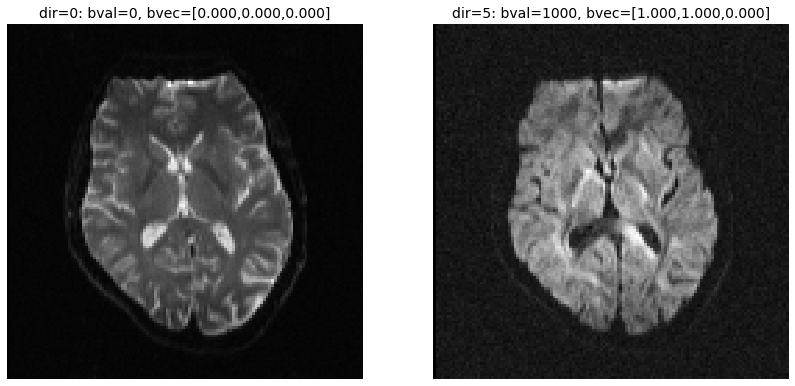

In [9]:
# Inspect data

plt.rcParams["figure.figsize"] = (14,7)

b1 = 0
b2 = 5
axial_slice = 3 # middle: data.shape[2] // 2

plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_slice, b1].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b1, bvals[b1], bvecs[b1][0],bvecs[b1][1], bvecs[b1][2]), size=14)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_slice, b2].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b2, bvals[b2], bvecs[b2][0],bvecs[b2][1], bvecs[b2][2]), size=14)
#plt.suptitle('DWI: sub-%d, ses-%d, slice no %d/%d' % (sub, ses, axial_middle, data.shape[2]), size=16)
#plt.savefig('./assets/dipy_data.png', bbox_inches='tight')
plt.show()

## Reconstruction of the diffusion signal with the Tensor model

See https://dipy.org/documentation/1.1.1./examples_built/reconst_dti/#example-reconst-dti

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994], it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

The diffusion tensor models the diffusion signal as:

$$\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}$$
    
Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of
measurement and $b$ are the parameters of measurement, such as the strength and
duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the
diffusion-weighted signal measured and $S_0$ is the signal conducted in a
measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite
quadratic form, which contains six free parameters to be fit. These six
parameters are:

$$\begin{split}\mathbf{D} = \begin{pmatrix} D_{xx} &  D_{xy} & D_{xz} \\
                    D_{yx} & D_{yy} & D_{yz} \\
                    D_{zx} & D_{zy} &  D_{zz} \\ \end{pmatrix}\end{split}$$
                    
This matrix is a variance/covariance matrix of the diffusivity along the three
spatial dimensions. Note that we can assume that diffusivity has antipodal
symmetry, so elements across the diagonal are equal. For example:
$D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate
here. In the following example we show how to reconstruct your diffusion datasets
using a single tensor model.

Now that we have prepared the datasets we can go forward with the voxel reconstruction.

`dipy.reconst` is for the reconstruction algorithms which we use to create voxel models from the raw data.

### First, we instantiate the Tensor model in the following way.

In [10]:
tenmodel = dti.TensorModel(gtab)

Fitting the data is very simple. We just need to call the fit method of the TensorModel in the following way:

In [11]:
%%time
tenfit = tenmodel.fit(data)

Wall time: 5.46 s


The fit method creates a TensorFit object which contains the fitting parameters and other attributes of the model. For example we can generate fractional anisotropy (FA) from the eigen-values of the tensor. FA is used to characterize the degree to which the distribution of diffusion in a voxel is directional. That is, whether there is relatively unrestricted diffusion in one particular direction.

Mathematically, FA is defined as the normalized variance of the eigen-values of the tensor:

$$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
            \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
            \lambda_2^2+\lambda_3^2}}$$
            
Note that FA should be interpreted carefully. It may be an indication of the
density of packing of fibers in a voxel, and the amount of myelin wrapping
these axons, but it is not always a measure of “tissue integrity”. For example,
FA may decrease in locations in which there is fanning of white matter fibers,
or where more than one population of white matter fibers crosses.

Other tensor statistics can be calculated from the tenfit object. For example, a commonly calculated statistic is the mean diffusivity (MD). This is simply the mean of the eigenvalues of the tensor. Since FA is a normalized measure of variance and MD is the mean, they are often used as complimentary measures. In DIPY, there are two equivalent ways to calculate the mean diffusivity. One is by calling the mean_diffusivity module function on the eigen-values of the TensorFit class instance.

In [12]:
print('Computing anisotropy measures (FA, MD, AD, RD, RGB)')

Computing anisotropy measures (FA, MD, AD, RD, RGB)


### Classes and functions for fitting tensors

See `dti??`  for more details

- def fractional_anisotropy(evals, axis=-1):

$$
       FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}
$$

- geodesic_anisotropy(evals, axis=-1):<br>
[1] P. G. Batchelor, M. Moakher, D. Atkinson, F. Calamante, A. Connelly, "A rigorous framework for diffusion tensor calculus", Magnetic Resonance in Medicine, vol. 53, pp. 221-225, 2005.
$$
        GA = \sqrt{\sum_{i=1}^3
        \log^2{\left ( \lambda_i/<\mathbf{D}> \right )}},
        \quad \textrm{where} \quad <\mathbf{D}> =
        (\lambda_1\lambda_2\lambda_3)^{1/3}
$$

- def mean_diffusivity(evals, axis=-1):<br>
$$
MD = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}
$$

- def axial_diffusivity(evals, axis=-1):<br>

$$
AD = \lambda_1
$$

- def radial_diffusivity(evals, axis=-1):<br>

$$
 RD = \frac{\lambda_2 + \lambda_3}{2}
$$

- def trace(evals, axis=-1):<br>

$$
 Trace = \lambda_1 + \lambda_2 + \lambda_3
$$

- def color_fa(fa, evecs):<br>
    rgb : Array with 3 channels for each color as the last dimension. Colormap of the FA with red for the x value, y for the green value and z for the blue value.

$$
     rgb = abs(max(\vec{e})) \times fa
$$

Note that while the tensor model is an accurate and reliable model of the
diffusion signal in the white matter, it has the drawback that it only has one
principal diffusion direction. Therefore, in locations in the brain that
contain multiple fiber populations crossing each other, the tensor model may
indicate that the principal diffusion direction is intermediate to these
directions. Therefore, using the principal diffusion direction for tracking in
these locations may be misleading and may lead to errors in defining the
tracks. Fortunately, other reconstruction methods can be used to represent the
diffusion and fiber orientations in those locations. These are presented in
other examples.

## Define function `tensor_features`

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser, join
import dipy
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity, axial_diffusivity, radial_diffusivity, color_fa

In [14]:
def tensor_features(inpdir, base_fn, brain_mask, outdir):
    r"""
    Fitting a tensor and calculating dti-derived features (FA, etc.) of a DWI recording (assuming BIDS).

    Parameters
    ----------
    inpdir     : input directory where the dwi, bvals and bvecs data lives
    base_fn    : base filename
    brain_mask : full path name of .nii.gz brain mask file obtained from 
    outdir     : output directory where resulting Dipy feature .nii.gz files are stored

    Returns
    -------
    FA, MD, AD, RD, RGB : arrays
    FA range is 0 <= FA <= 1
    RGB : Array with 3 channels for each color as the last dimension. 
          Colormap of the FA with red for the x value, y for the green value and z for the blue value.

    Notes
    -----
    FA, MD, AD, RD, RGB are calculated using the following equations:

    .. math::

        FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}
                    
        MD = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}
        
        
        AD = \lambda_1
        
        RD = \frac{\lambda_2 + \lambda_3}{2}
        
        rgb = abs(max(\vec{e})) \times FA

    """
    
    fn = base_fn
    fdwi = join(inpdir, '%s.nii.gz' % fn)
    fbval = join(inpdir, '%s.bval' % fn)
    fbvec = join(inpdir, '%s.bvec' % fn)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    # Invert the column axis
    data = data[:,::-1,:,:]
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    # Normalize the b-vectors to be unit vectors for those directions having b-value > 0 ( needed by gradient_table() )
    bvecs_norm = bvecs.copy()
    for i in range(bvecs.shape[0]):
        mag = np.sqrt(bvecs[i,:].dot(bvecs[i,:]))
        if (mag > 0):
            bvecs_norm[i,:] = bvecs[i,:] / mag
    
    gtab = gradient_table(bvals, bvecs_norm)
    
    # Brain mask (binary)

    #fn_dwi_bin_msk =  brain_mask
    
    #dwi_bin_msk_data, dwi_bin_msk_affine, dwi_bin_msk_img = load_nifti(fn_dwi_bin_msk, return_img=True)             
    
    # using broadcasting in numpy to obtain brain-mask in 4D (according to dwi shape)            
    #dwi_4d_mask = dwi_bin_msk_data[:,:,:,np.newaxis]*data
    dwi_4d_mask = data
    
    # Tensor model and model fitting
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(dwi_4d_mask)
    
    FA = fractional_anisotropy(tenfit.evals)
    
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    
    MD = mean_diffusivity(tenfit.evals)
    AD = axial_diffusivity(tenfit.evals)
    RD = radial_diffusivity(tenfit.evals)
    
    RGB = color_fa(FA, tenfit.evecs)
    
    # fname = join(outdir, 'sub_%d_tp%d_dwi_brainmask' % (sub, ses))
    fname = join(outdir, '%s' % base_fn)
    save_nifti(fname + '_tensor_fa.nii.gz', FA.astype(np.float32), affine)
    save_nifti(fname + '_tensor_md.nii.gz', MD.astype(np.float32), affine)
    save_nifti(fname + '_tensor_ad.nii.gz', AD.astype(np.float32), affine)
    save_nifti(fname + '_tensor_rd.nii.gz', RD.astype(np.float32), affine)
    
    save_nifti(fname + '_tensor_evals.nii.gz', tenfit.evals.astype(np.float32), affine)
    save_nifti(fname + '_tensor_evecs.nii.gz', tenfit.evecs.astype(np.float32), affine)
    
    save_nifti(fname + '_tensor_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine)

    return FA, MD, AD, RD, RGB


### Test the function

In [15]:
%%time
inpdir = join(os.getcwd(), 'data', 'westin_2002')
outdir = join(os.getcwd(), 'data', 'westin_2002')

base_fn = 'D6_19x7x128x128'
brain_mask = join(outdir,'%s_dummy_mask.nii.gz' % base_fn)

FA, MD, AD, RD, RGB = tensor_features(inpdir, base_fn, brain_mask, outdir)

Wall time: 6.43 s


## $\rightarrow$ YOUR TURN!

- Construct an ad hoc algorithm that segments the brain (cf. `brain_mask`)

In [16]:
# Requires installation of FSL:
# !fsleyes ./data/westin_2020/D6_19x7x128x128_tensor_rgb.nii.gz

In [17]:
FA.shape

(128, 128, 19)

In [18]:
FA.mean().round(4)

0.6492

In [19]:
help(tensor_features)

Help on function tensor_features in module __main__:

tensor_features(inpdir, base_fn, brain_mask, outdir)
    Fitting a tensor and calculating dti-derived features (FA, etc.) of a DWI recording (assuming BIDS).
    
    Parameters
    ----------
    inpdir     : input directory where the dwi, bvals and bvecs data lives
    base_fn    : base filename
    brain_mask : full path name of .nii.gz brain mask file obtained from 
    outdir     : output directory where resulting Dipy feature .nii.gz files are stored
    
    Returns
    -------
    FA, MD, AD, RD, RGB : arrays
    FA range is 0 <= FA <= 1
    RGB : Array with 3 channels for each color as the last dimension. 
          Colormap of the FA with red for the x value, y for the green value and z for the blue value.
    
    Notes
    -----
    FA, MD, AD, RD, RGB are calculated using the following equations:
    
    .. math::
    
        FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3

### Display FA-map and color(RGB)-coded diffusion map for given image slice

In [20]:
RGB.shape

(128, 128, 19, 3)

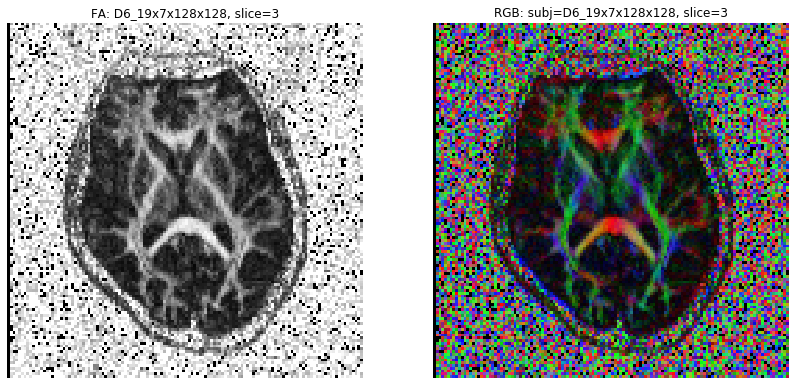

In [21]:
from matplotlib.pyplot import imshow

sl =  3   # FA.shape[2] // 2 # axial_middle slice

plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(FA[:, :, sl].T, cmap='gray', origin='lower')
plt.title('FA: %s, slice=%d' % (base_fn, sl))

plt.subplot(1, 2, 2).set_axis_off()
img1 = np.squeeze((RGB[:, :, sl, :]))
img = np.transpose(img1, (1, 0, 2))
plt.imshow(img, origin='lower')
plt.title('RGB: subj=%s, slice=%d' % (base_fn, sl))
plt.show()

## $\rightarrow$ YOUR TURN!

- Make a figure (2x3 matrix of panels) showing all the derived maps: S0, FA, MD, AD, RD, RGB <br>
  (if you have constructed a `brain_mask`, apply this)

# EXTRA

## $\rightarrow$ YOUR TURN!

- Do the following conversion from MATLAB to Python (incl. the figures)

# MATLAB code to be translated to Python

cf. .... BMED_360/Lab3/m-files/`dti_6_demo_westin_2002.m` and <br>
Westin CF et al. *Processing and visualization for diffusion tensor MRI*. Medical Image Analysis 2002;6:93-108.
https://www.ncbi.nlm.nih.gov/pubmed/12044998  [[PDF](https://drive.google.com/file/d/1WkAbJi3Xh4sdDdBMiu9yuXEU9UzGKKSs/view?usp=sharing)]

```shell
function r = dti_6_demo_westin_2002(DTI, sliceno)
% dti_6_demo_westin_2002.m
% Arvid Lundervold, 31-MAR-2005,1-APR-2007, 20-OCT-2010, 06-APR-2016, 29-APR-2020 (MATLAB R2020a)
% cf. BMED 360 Lab3 - Processing of MR-DTI Part 1
% http://sites.google.com/site/bmed360
%
% Implementation based on the paper by CF Westin et al.
% Processing and visualization for diffusion tensor MRI
% Medical Image Analysis 2002;6:93-108
%
% Providing a GUI for slice number:    r = dti_6_demo_westin_2002;
% Without GUI:                         r = dti_6_demo_westin_2002(DTI, sliceno);
% INPUT:
%   DTI  either a struct containg    DTI.D=D_6  and  DTI.enc=diff_enc_dirs_6
%        or a number, e.g. 0 (in case the default data D6.mat is loaded)
%   sliceno - slice number to be processed
% OUTPUT:
%   r.D -
%   r.D_trace -
%   r.EIGval -
%   r.EIGvec -
%   r.FA -
%   r.RGB -

global SMALL_SCREEN

if nargin == 0
    GUI = 1;
    DISP = 1;
    DTI = 0;
elseif nargin == 2
    GUI = 0;
    DISP = 0;
    s_disp = sliceno;
else
    fprintf('\nERROR: Invalid number of arguments (%d)\n', nargin);
    return
end

SMALL_SCREEN = 1;
TEST = 0;  % No testing

if isstruct(DTI)
    D_6 = DTI.D;
    diff_enc_dirs_6 = DTI.enc;
else
    load './data/westin_2002/D6.mat'
end


[ns, nd, nr, nc] = size(D_6);
if GUI == 0
    if s_disp < 1 | s_disp > ns 
        fprintf('ERROR: Invalid slice number (%d) . must be in 1,...,%s\n', s_disp, ns);
        return
    end
end

if GUI == 1
    txt = sprintf('DTI-volume consists of %d slices (%d x %d matrix) \nwith %d diffusion sensitizing directions\n\n Continue?', ...
        ns, nr, nc, nd-1); 
    quest_ans = questdlg(txt, 'DTI info', 'Yes', 'No', 'Yes');
    if strcmp(quest_ans, 'No')
        return
    end
    
    s_disp = 0;
    while s_disp < 1 | s_disp > ns
        txt = sprintf('Select slice  1 <= s <= %d :', ns);
        answ = inputdlg({txt,}, 'SELECT SLICE', 1, {'4'});
        s_disp = str2num(answ{1});
    end
    
end % GUI      


if DISP == 1
    nrow=3;
    ncol=3;
    for s=s_disp:s_disp
        im = reshape(D_6(s,1,:,:), nr, nc);
        
        mn=min(min(im)); mx=max(max(im));
        figure(s)
        imagesc(im, [mn mx]), axis image, axis off, colormap(gray);
        txt = sprintf('Slice #%d/%d: b=0', s, ns);
        title(txt, 'FontSize', 14);
        if SMALL_SCREEN == 1
            set(gcf, 'Position',  [61 42 754 644]);
        else
            set(gcf, 'Position',  [55 705 473 353]);
        end
    end
    for d=2:nd
        im = reshape(D_6(s,d,:,:), nr, nc);
        fno = ns+s;
        switch d
            case 2
                lcl_plot_subimage(fno, nrow, ncol, 1, im, diff_enc_dirs_6{1}, 1);
            case 3
                lcl_plot_subimage(fno, nrow, ncol, 2, im, diff_enc_dirs_6{2}, 1);   
            case 4
                lcl_plot_subimage(fno, nrow, ncol, 3, im, diff_enc_dirs_6{3}, 1);
            case 5
                lcl_plot_subimage(fno, nrow, ncol, 5, im, diff_enc_dirs_6{4}, 1);  
            case 6
                lcl_plot_subimage(fno, nrow, ncol, 6, im, diff_enc_dirs_6{5}, 1);
            case 7
                lcl_plot_subimage(fno, nrow, ncol, 9, im, diff_enc_dirs_6{6}, 1);
            otherwise
                disp('Unknown direction.')
        end
        lcl_plot_diffdir(fno, nrow, ncol, 7, nd-1, diff_enc_dirs_6);
    end
    %pause(3.0)
end  % DISP


% Make a (AD HOC) mask with brain only
L_THR = 300;  % By inspection of histograms ...
D_6_slice = reshape(D_6(s_disp,:,:,:), nd, nr, nc);
M = lcl_make_brain_mask(D_6_slice, L_THR, DISP);
%r = 1;
%return


if TEST == 1
    ghat = lcl_normalized_dirvec(nd-1, diff_enc_dirs_6);
    G_k = lcl_tensor_basis_element(1, diff_enc_dirs_6);
    G = lcl_stacked_tensor_basis(nd-1, diff_enc_dirs_6);
    G_tilde = lcl_stacked_dual_tensor_basis(nd-1, diff_enc_dirs_6);
    %G_tilde * G
    x = zeros(3,3);
    for k=1:nd-1;
        %fprintf('k=%d:\n', k);
        G_tilde_k = lcl_dual_tensor_basis_element(k, nd-1, diff_enc_dirs_6);
        x = x + k*G_tilde_k;
    end
    %x
end % TEST




D_6_slice = reshape(D_6(s_disp,:,:,:), nd, nr*nc);
D = zeros(9,nr*nc);
D_6_0 = D_6_slice(1,:)+1; 
D_6_k = zeros(nd-1,nr*nc);
beta_k = zeros(nd-1,nr*nc);
for k=1:nd-1
    D_6_k(k,:) = D_6_slice(k+1,:)+1;
    beta_k(k,:) = (1/1000) * (log( D_6_0 ) - log( D_6_k(k,:) ));
end

x=zeros(9,nr*nc);
for k=1:nd-1
    G_tilde_k = lcl_dual_tensor_basis_element(k, nd-1, diff_enc_dirs_6);
    x = x + ( ones(9,1)*reshape(beta_k(k,:),1,nr*nc) ) .* ( reshape(G_tilde_k, 9, 1)*ones(1,nr*nc) );
end
D = x;
EIGval = zeros(3,nr*nc);
EIGvec = zeros(3,3,nr*nc);  % zeros(9,nr*nc);
for i=1:nr*nc;
    Di = reshape(D(:,i), 3,3);
    [eigenvec, eigenval] = eig(Di);  % eigs(Di) is much slower
    [val, I] = sort(-diag(eigenval));
    for j=1:3;
      vec(1:3,j) = eigenvec(1:3,I(j));
    end
    EIGval(:,i) = -val;
    EIGvec(:,:,i) = reshape(vec,3,3,1);
end

if DISP == 1
    lcl_display_diff_tensor(D, nr, nc, diff_enc_dirs_6, 0);
end

txt = sprintf('Slice #%d/%d: DTI trace', s_disp, ns);
D_trace = lcl_display_diff_trace(D, nr, nc, M, txt, DISP);

txt = sprintf('Slice #%d/%d: FA', s_disp, ns);
FA = lcl_display_fractional_anisotropy(EIGval, nr, nc, M, txt, DISP);

txt = sprintf('Slice #%d/%d: ', s_disp, ns);
RGB = lcl_display_diff_rgb(EIGval, EIGvec, FA, nr, nc, M, txt, DISP);


r.D = D;
r.D_trace = D_trace;
r.EIGval = EIGval;
r.EIGvec = EIGvec;
r.FA = FA;
r.RGB = RGB; 
r.M = M;

return
%==========================================================================
% Local functions


function [] = lcl_plot_subimage(fno, nrow, ncol, no, im, diffdir, tit)

global SMALL_SCREEN
mn = min(min(im)); mx = max(max(im));
figure(fno)
if SMALL_SCREEN == 1
    set(gcf, 'Position', [15 36 687 660]);
else
    set(gcf, 'Position', [485 265 840 687]);
end
subplot(nrow, ncol, no)
imagesc(im, [mn mx]), axis image, axis off, colormap(gray);
if tit == 1
    txt = sprintf('(%.0f, %.0f, %.0f)', ...
        diffdir(1), diffdir(2), diffdir(3));
    title(txt, 'FontSize', 14)
end
pause(0.05)
return


%--------------------------------------------------------------------------
function [] = lcl_plot_diffdir(fno, nrow, ncol, no, nofdir, diffdirs)

global SMALL_SCREEN

X = zeros(1,nofdir);
Y = zeros(1,nofdir);
Z = zeros(1,nofdir);
for n = 1:nofdir
  X(n) = diffdirs{n}(1);
  Y(n) = diffdirs{n}(2);
  Z(n) = diffdirs{n}(3);
end

figure(fno)
if SMALL_SCREEN == 1
    set(gcf, 'Position', [26 37 741 650]);
else
    set(gcf, 'Position', [485 265 840 687]);
end
subplot(nrow, ncol, no)
for n=1:nofdir
    plot3([0, X(n)], [0,  Y(n)], [0, Z(n)], 'LineWidth', 1.5);
    txt=sprintf(' ''%d'' ', n);
    text(X(n), Y(n), Z(n), txt);
    axis([-1 1 -1 1 -1 1]);
    xlabel('x-dir'), ylabel('y-dir'), zlabel('z-dir');
    grid on,
    hold on,
end
hold off
txt = sprintf('The %d directions (b=1000)', nofdir);
title(txt, 'FontSize', 14);

pause(0.05)
return


%--------------------------------------------------------------------------
function ghat = lcl_normalized_dirvec(nofdir, diffdirs)

ghat = zeros(3, nofdir+1);
g = ghat;
X = zeros(1,nofdir);
Y = zeros(1,nofdir);
Z = zeros(1,nofdir);
for n = 1:nofdir
  X(n) = diffdirs{n}(1);
  Y(n) = diffdirs{n}(2);
  Z(n) = diffdirs{n}(3);
  g(:,n+1) = [X(n); Y(n); Z(n)]; 
  ghat(:,n+1)= g(:,n+1) ./ sqrt(g(:,n+1)'*g(:,n+1));
end
return


%--------------------------------------------------------------------------
function G_k = lcl_tensor_basis_element(k, diffdirs)

g_k = [diffdirs{k}(1); diffdirs{k}(2); diffdirs{k}(3)];
ghat_k = g_k ./ sqrt(g_k'*g_k);
G_k = ghat_k * ghat_k';
return


%--------------------------------------------------------------------------
function G = lcl_stacked_tensor_basis(nofdir, diffdirs)

G = zeros(9,nofdir);
for k=1:nofdir
    G_k = lcl_tensor_basis_element(k, diffdirs);
    G(:,k) = reshape(G_k, 9,1);
end
return


%--------------------------------------------------------------------------
function G_tilde = lcl_stacked_dual_tensor_basis(nofdir, diffdirs)

G_tilde = zeros(9,nofdir);
G = lcl_stacked_tensor_basis(nofdir, diffdirs);
% The rows of the pseudoinverse contain the dual basis elements
G_tilde = pinv(G);
return


%--------------------------------------------------------------------------
function G_tilde_k = lcl_dual_tensor_basis_element(k, nofdir, diffdirs)

G_tilde_k = zeros(3,3);
G_tilde = lcl_stacked_dual_tensor_basis(nofdir, diffdirs);
G_tilde_k = reshape(G_tilde(k,:), 3, 3);
return


%--------------------------------------------------------------------------
function [] = lcl_display_diff_tensor(D, nr, nc, diffdirs, tit)

fno = 100;
nrow = 3;
ncol = 3;
nd=7;

for d=1:9   % [1,2,3,5,6,9]
    im = reshape(D(d,:), nr, nc);
    lcl_plot_subimage(fno, nrow, ncol, d, im, diffdirs{1}, tit);
end
%lcl_plot_diffdir(fno, nrow, ncol, 7, nd-1, diffdirs);
return


%--------------------------------------------------------------------------
function [tr] = lcl_display_diff_trace(D, nr, nc, M, txt, DISP)

global SMALL_SCREEN

fno = 110;

tr=zeros(nr,nc);
for d = [1,5,9]
    im = reshape(D(d,:), nr, nc);
    tr = tr + im;
end
tr = tr / 3;
tr_M = tr .* M;

if DISP == 1
    mn = min(min(tr_M)); mx = max(max(tr_M));
    figure(fno)
    if SMALL_SCREEN == 1
        set(gcf, 'Position', [5 33 712 656]);
    else
        set(gcf, 'Position', [485 265 840 687]);
    end
    imagesc(tr_M, [mn mx]), axis image, axis off, colormap(gray);
    title(txt, 'FontSize', 14)
    pause(0.05)
end  % DISP

return


%--------------------------------------------------------------------------
function [FA] = lcl_display_fractional_anisotropy(EIGval, nr, nc, M, txt, DISP)

global SMALL_SCREEN

fno = 120;

WIENER = 0;
c = 1/sqrt(2);
FA_vec=zeros(1,nr*nc);
epsi = 1e-100;
for i=1:nr*nc;
    l1 = EIGval(1,i);
    l2 = EIGval(2,i);
    l3 = EIGval(3,i);
    numer = sqrt((l1-l2)*(l1-l2) + (l2-l3)*(l2-l3) + (l1-l3)*(l1-l3));
    denumer = max(sqrt(l1*l1+l2*l2+l3*l3), epsi);
    %denumer = sqrt(l1*l1+l2*l2+l3*l3);
    FA_vec(i) = c*numer/denumer; % min(c*numer/denumer, 1.0);
    %if FA_vec(i) > 1.0001
    %    FA_vec(i) = NaN;
    %end
end
FA = reshape(FA_vec,nr,nc);

FA_M = FA .* M;

if DISP == 1
    mn = min(min(FA_M)); mx = max(max(FA_M));
    figure(fno)
    if SMALL_SCREEN == 1
        set(gcf, 'Position', [40 32 733 660]);
    else
        set(gcf, 'Position', [485 265 840 687]);
    end
    
    if WIENER == 1
        [FA_wiener,NOISE] = wiener2(FA_M,[3 3]);
        imagesc(FA_wiener, [mn mx]), axis image, axis off, colormap(gray);
    else
        imagesc(FA_M, [mn mx]), axis image, axis off, colormap(gray);
    end
    txt2 = sprintf('%s  min=%.2f, max=%.2f', txt, mn, mx);
    title(txt2, 'FontSize', 14)
    pause(0.05)
end % DISP

return


%--------------------------------------------------------------------------
function [RGB] = lcl_display_diff_rgb(EIGval, EIGvec, FA, nr, nc, M, txt, DISP)

global SMALL_SCREEN

fno = 130;

WIENER = 0;
FA_vec = reshape(FA, 1, nr*nc);
RGB=zeros(nr,nc,3);
lambda1 = zeros(1,nr*nc);
v1x = zeros(1,nr*nc);
v1y = zeros(1,nr*nc);
v1z = zeros(1,nr*nc);
for i=1:nr*nc;
    lambda1(i) = EIGval(1,i);
    x = EIGvec(1,1,i); % x-component of eigenvector corresponding to largest eigenvalue
    y = EIGvec(2,1,i); % y-comp.
    z = EIGvec(3,1,i); % z-comp.
    v = [x, y, z]';
    vn = v / sqrt(v'*v);
    v1x(i) = abs(FA_vec(i)*vn(1));
    v1y(i) = abs(FA_vec(i)*vn(2));
    v1z(i) = abs(FA_vec(i)*vn(3));
end
V1x = reshape(v1x,nr,nc);
V1y = reshape(v1y,nr,nc);
V1z = reshape(v1z,nr,nc);

if WIENER == 1
    [R, noise_r] = wiener2(V1x,3,3); % ./ max(max(V1x)); 
    [G, noise_g] = wiener2(V1y,3,3); %  ./ max(max(V1y)); 
    [B, noise_b] = wiener2(V1z,3,3); % ./ max(max(V1z)); 
else
    R = V1x; % ./ max(max(V1x)); 
    G = V1y; %  ./ max(max(V1y)); 
    B = V1z; % ./ max(max(V1z)); 
end

R_M = R .* M;
G_M = G .* M;
B_M = B .* M;

RGB(:,:,1) = R ./ max(max(R));
RGB(:,:,2) = G ./ max(max(G));
RGB(:,:,3) = B ./ max(max(B));

RGB_M(:,:,1) = R_M ./ max(max(R));
RGB_M(:,:,2) = G_M ./ max(max(G));
RGB_M(:,:,3) = B_M ./ max(max(B));

if DISP == 1
    figure(fno)
    imshow(RGB_M);
    if SMALL_SCREEN == 1
        set(gcf, 'Position', [141 41 862 658]);
    else
        set(gcf, 'Position', [485 265 840 687]);
    end
    txt2 = sprintf('%s  R = FA*|v1_x|, G = FA*|v1_y|, B = FA*|v1_z|', txt);
    title(txt2, 'FontSize', 14)
    pause(0.05)
end %DISP

return


%--------------------------------------------------------------------------
function [M] = lcl_make_brain_mask(D_slice, thr, DISP)

global SMALL_SCREEN

HSIZE = 5; 
SIGMA = 3.0;
L_THRES = thr;

[nd, nr, nc] = size(D_slice);
im =zeros(nr,nc);
for d=1:nd
    im = im + reshape(D_slice(d,:,:), nr, nc);
end
im = im/nd;

H = fspecial('gaussian', HSIZE, SIGMA);
im1 = imfilter(im, H);

% 2-D order statistics filtering
%im2 = ordfilt2(im1, 1, ones(3,3));
im2 = im1;

mn = min(min(im2)); mx = max(max(im2));
M = roicolor(im2, L_THRES, mx);

% Outlined original image
im3 = bwperim(M);
im4 = im; 
im4(im3) = max(max(im2)); % 255; 

if DISP == 1
    fno = 101;
    figure(fno)
    if SMALL_SCREEN == 1
        set(gcf, 'Position', [15 36 687 660]);
    else
        set(gcf, 'Position', [485 265 840 687]);
    end
    subplot(1,2,1)
    imagesc(M, [0 1]), axis image, axis off, colormap(gray);
    txt = sprintf('ROI (for estimation of DTI)');
    title(txt, 'FontSize', 12)
    subplot(1,2,2)
    imagesc(im4, [mn mx]), axis image, axis off, colormap(gray);
    txt = sprintf('Brain outer contour:  min=%.2f, max=%.2f', mn, mx);
    title(txt, 'FontSize', 12)
end % DISP

return
```

### Figures in MATLAB (the m-script above)  to be made in Matplotlib

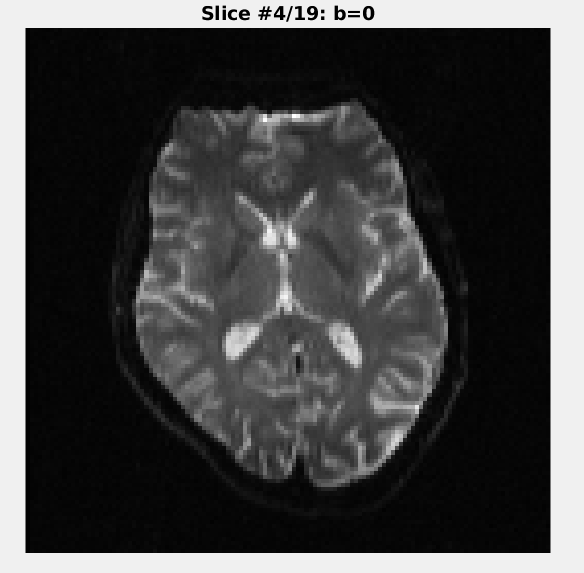

In [22]:
import IPython
IPython.display.Image("./assets/matlab_fig_4.png", width="50%")

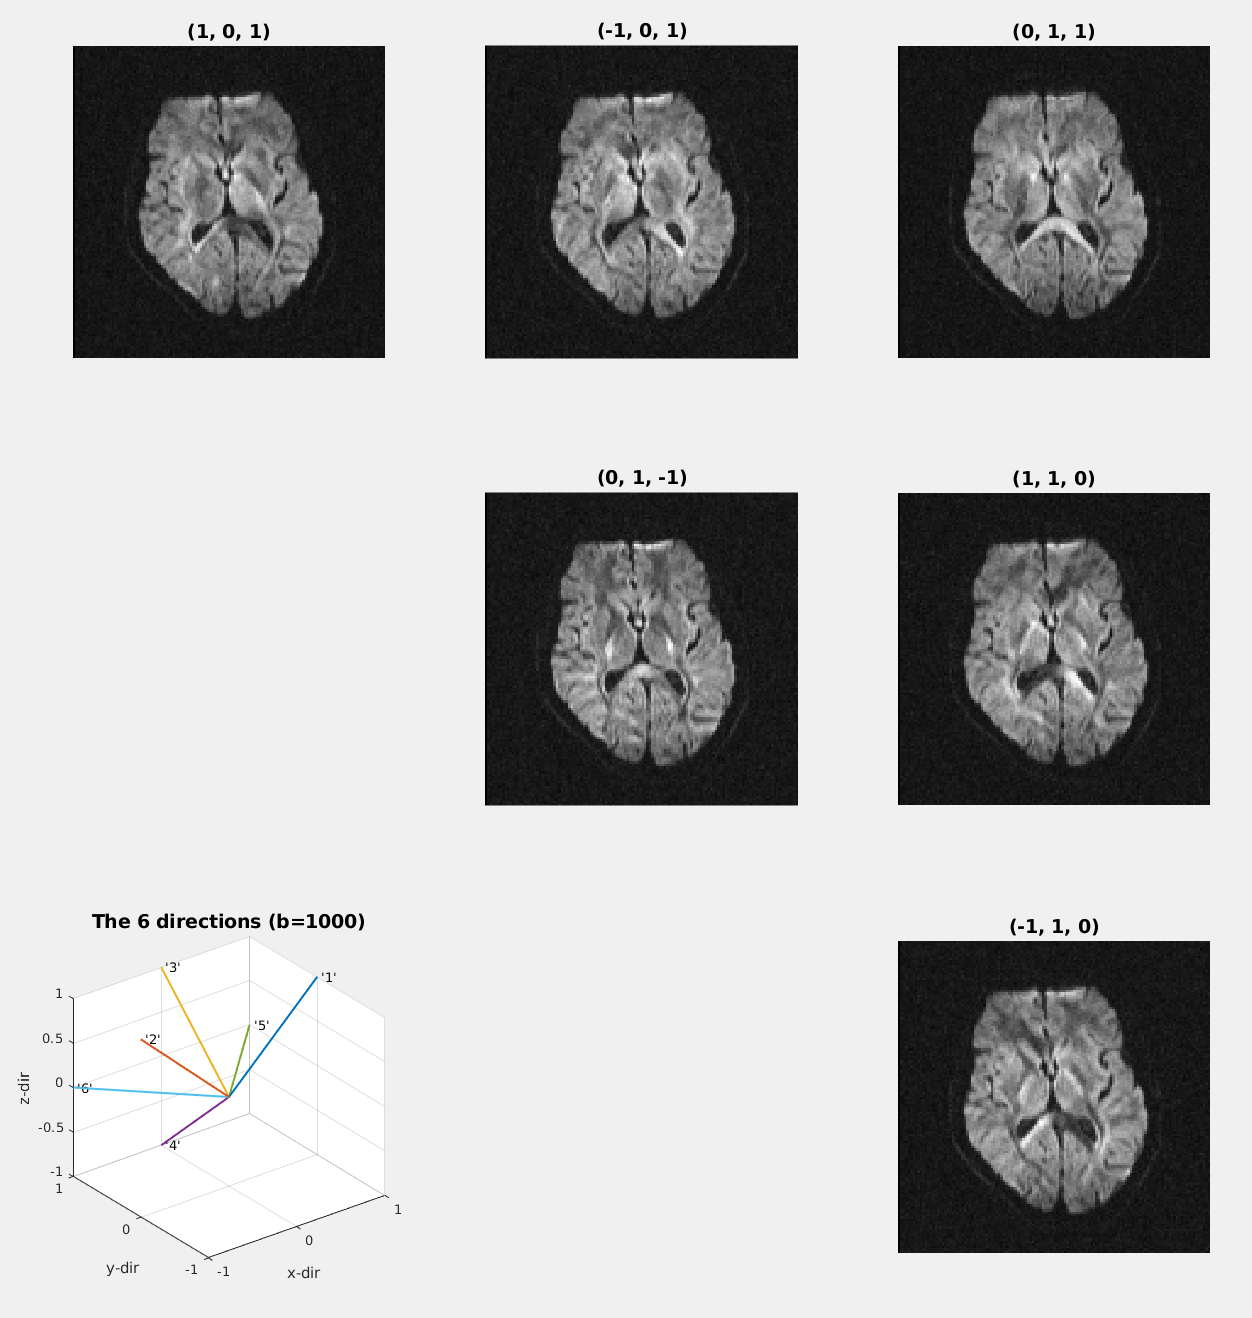

In [23]:
import IPython
IPython.display.Image("./assets/matlab_fig_23.png", width="70%")

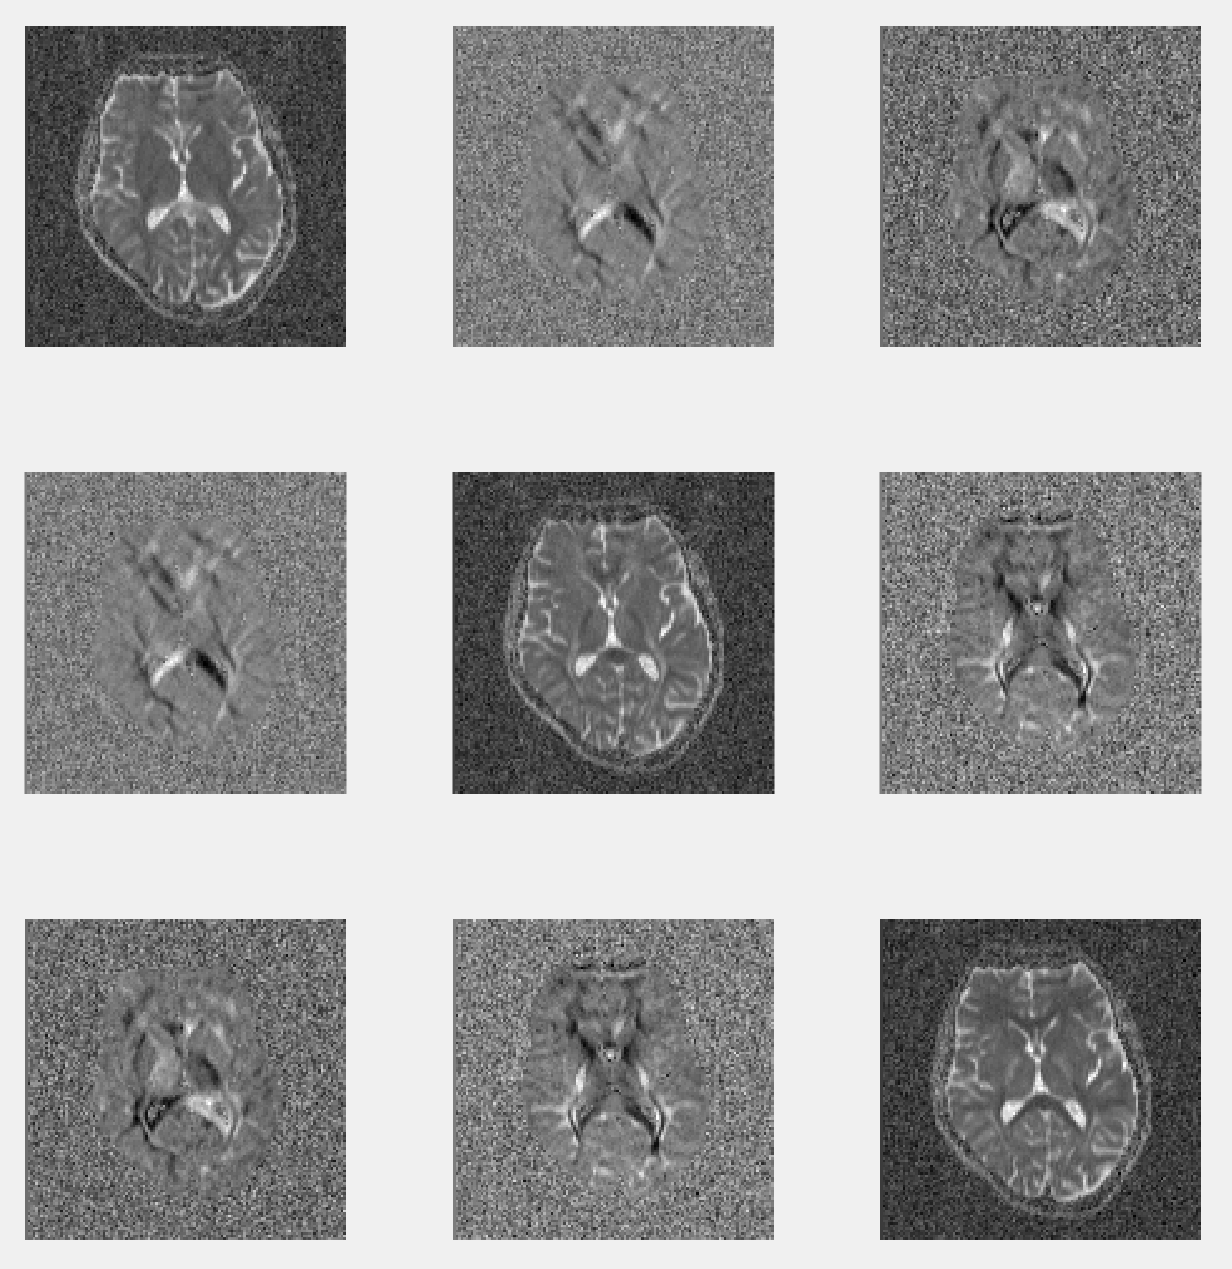

In [24]:
import IPython
IPython.display.Image("./assets/matlab_fig_100.png", width="70%")

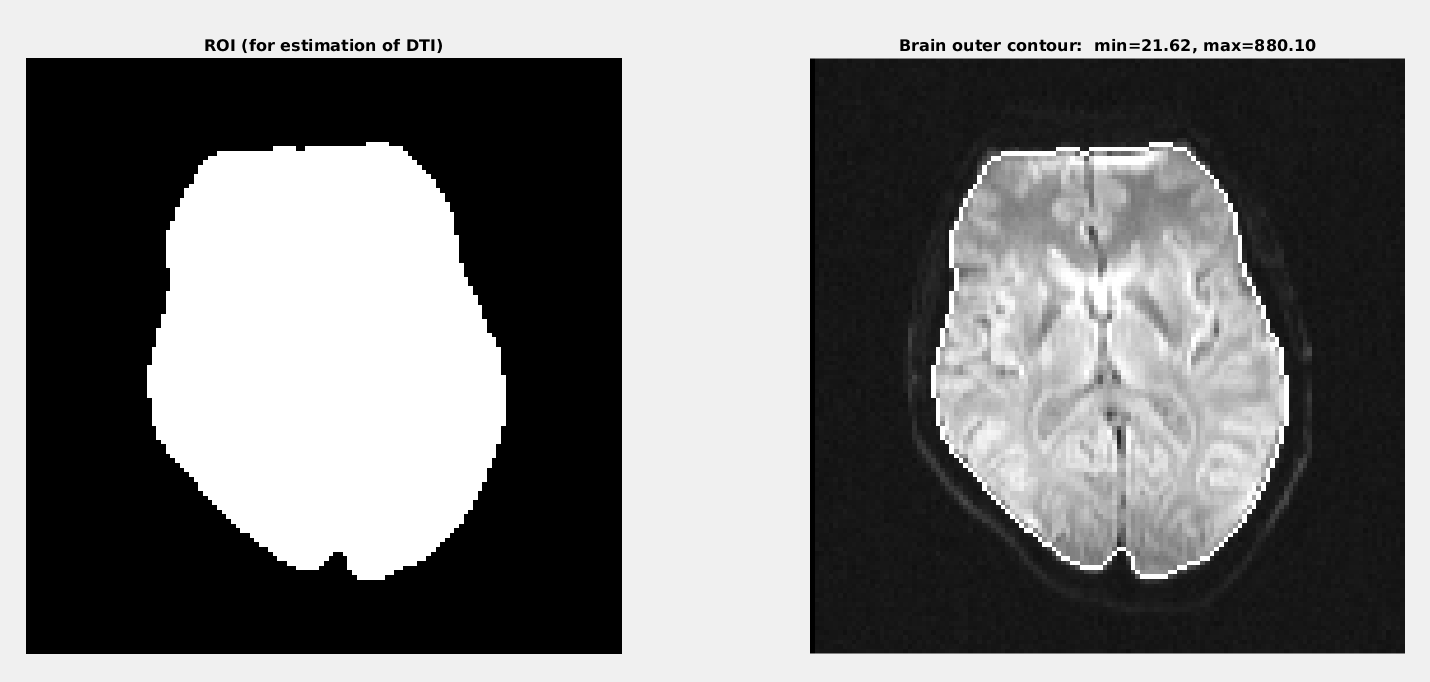

In [25]:
import IPython
IPython.display.Image("./assets/matlab_fig_101.png", width="70%")

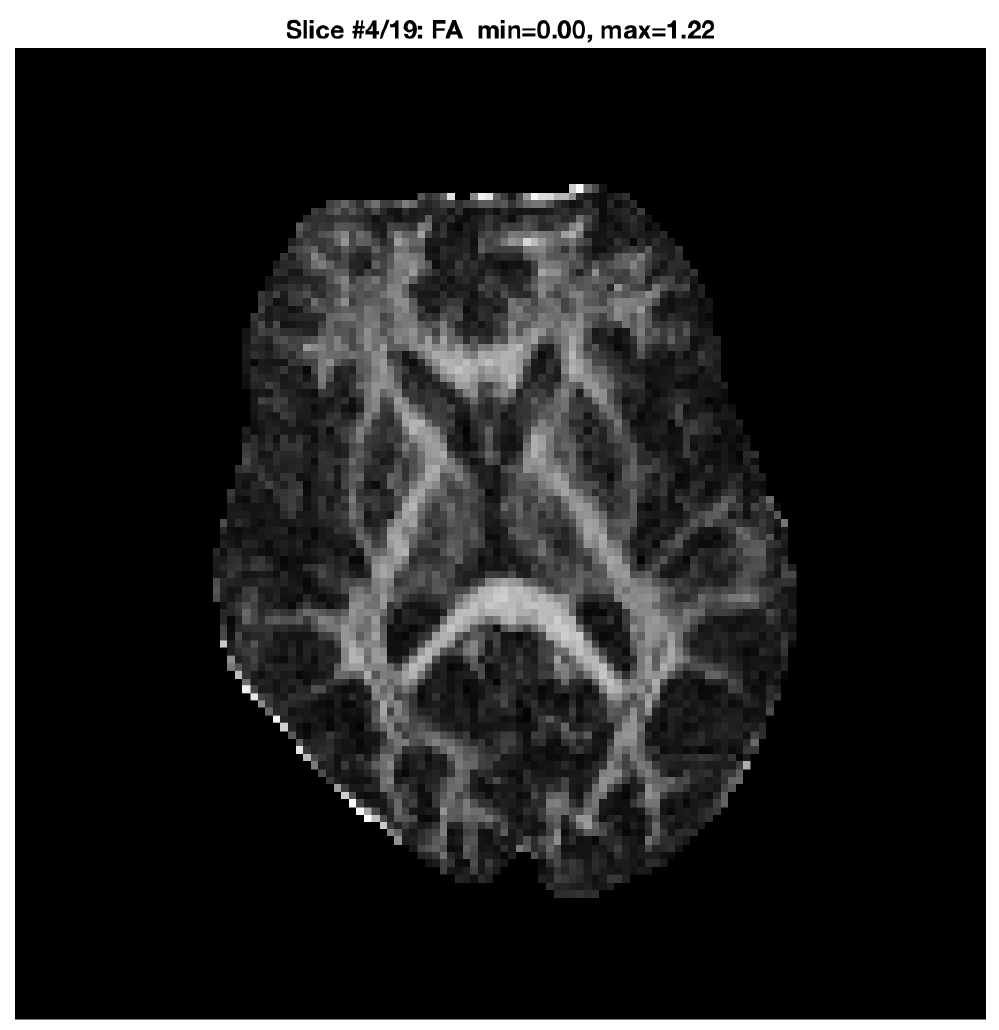

In [26]:
import IPython
IPython.display.Image("./assets/matlab_fig_120.png", width="60%")

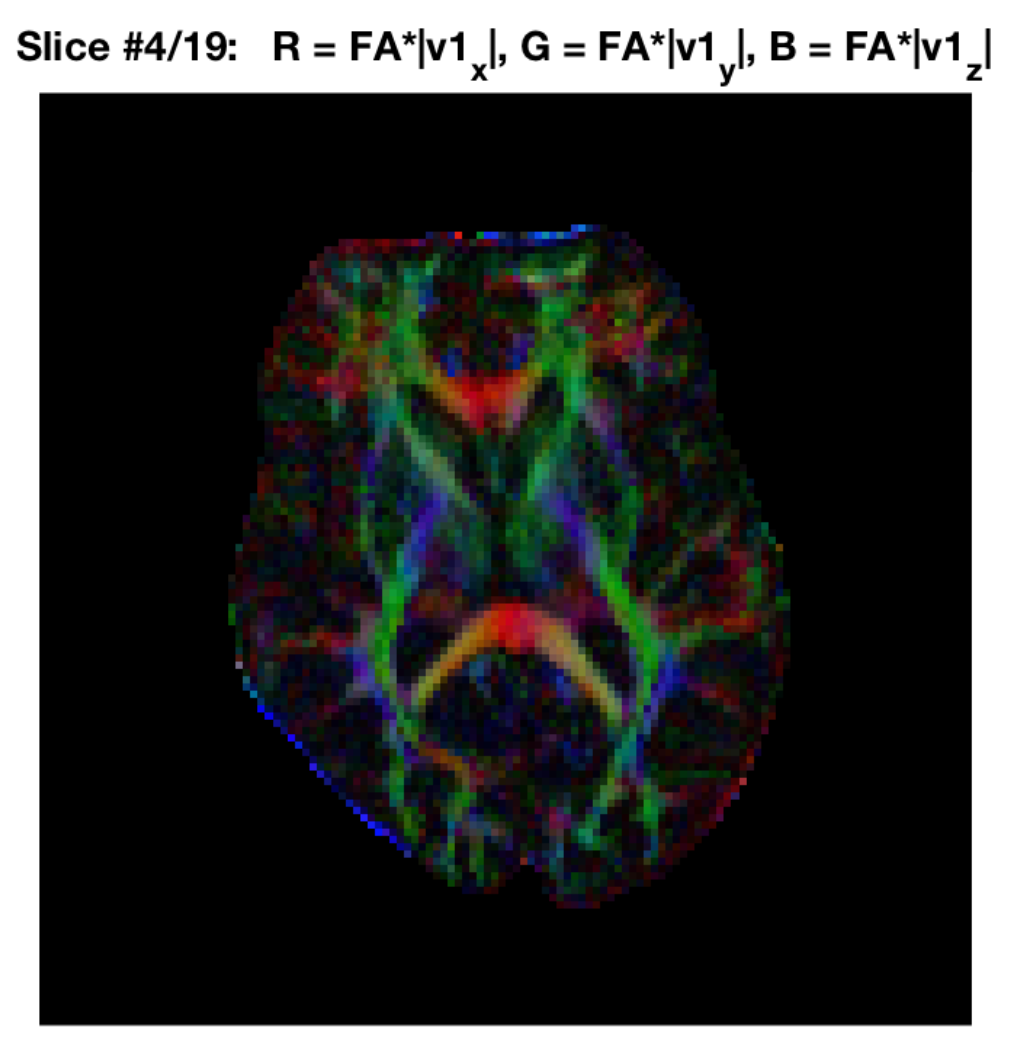

In [27]:
import IPython
IPython.display.Image("./assets/matlab_fig_130.png", width="60%")